# Explore resting state BOLD fMRI data (work in progress ...)

BMED360-2021  `03-Resting-state-fmri-explore.ipynb`

(using selected datasets from the Brain-Gut BIDS collection and open data from Nilearn and OpenNeuro) 

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab6-Networks-Graphs/03-Resting-state-fmri-explore.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Learning objectives:


Three major topics


- #### The nature of 4D (3D+time) resting state BOLD fMRI data
See also: _What is meant by resting state fMRI? How is it used?_ in [[mriquestions.com](http://mriquestions.com/resting-state-fmri.html)] <br>
and Gili Karni's _Identifying Resting-State Networks from fMRI Data Using ICAs -
A hands-on tutorial: from data collection to feature extraction_ [[here](https://towardsdatascience.com/exploring-cognitive-differences-via-resting-state-networks-2112bf5291e2)] and [[here](https://github.com/karnigili/Computational-Neuroscience)]<br>
List of functional connectivity software on Wikipedia is [[here](https://en.wikipedia.org/wiki/List_of_functional_connectivity_software)].


- #### BIDS: Brain Imaging Data Structure
The Brain Imaging Data Structure (BIDS) is a standard prescribing a formal way to name and organize MRI data and metadata in a file system that simplifies communication and collaboration between users and enables easier data validation and software development through using consistent paths and naming for data files. (See: https://bids.neuroimaging.io and https://training.incf.org/lesson/introduction-brain-imaging-data-structure-bids).<br> We will be using `pybids` (https://github.com/bids-standard/pybids) (included by `pip install pybids` in the `environment.yml`file) to access the `./data/bids_bg_bmed360` information (e.g. `participants.tsv`)

- #### Open science with Open data (BIDS validated)
E.g. Explore the **OpenNeuro** collection:  https://openneuro.org/datasets/ds000030/versions/1.0.0 + https://f1000research.com/articles/6-1262/v2<br>
How to download such a large dataset (Files: 9010, Size: 79.28GB, Subjects: 272) using the AWS Command Line Interface (https://aws.amazon.com/cli). The `derivatives` are the preprocessed data using `fmriprep`.
```
aws s3 sync --no-sign-request s3://openneuro.org/ds000030 ds000030-download/
aws s3 sync --no-sign-request s3://openneuro/ds000030/ds000030_R1.0.5/uncompressed/derivatives/ ds000030-derivatives-download/
```
Bilder, R and Poldrack, R and Cannon, T and London, E and Freimer, N and Congdon, E and Karlsgodt, K and Sabb, F (2020). UCLA Consortium for Neuropsychiatric Phenomics LA5c Study. OpenNeuro. [Dataset] doi: 10.18112/openneuro.ds000030.v1.0.0

### Some instructive videos on resting state fMRI and the BIDS - Brain Imaging Data Structure

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/1A76JgNrEqI" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

In [2]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/DavxePlS94w" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

In [3]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/kxj0PLyzYsg" 
frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

## Setup

In [4]:
# Set this to True if you are using Colab:
colab=False

#### For using Google Colab
**--> (some of) the following libraries must be `pip installed`):**

In [5]:
if colab:
    !pip install gdown
    !pip install nibabel
    !pip install pybids
    !pip install nilearn

In [6]:
# We will be using pybids in our bmed360 environment, if not already installed: uncomment the following
#!pip install pybids

### Set up libraries and folders

In [7]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import bids
from nilearn import datasets, plotting, image
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

/Users/arvid/opt/anaconda3/envs/bmed360/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [8]:
cwd = os.getcwd()

In [9]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
openneuro_dir = '%s/OpenNeuro' % (working_dir)
assets_dir =  join(cwd, 'assets')
sol_dir =  join(cwd, 'solutions')

Check your platform for running this notebook

In [10]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Thu Apr 22 21:46:47 PDT 2021; root:xnu-7195.101.2~1/RELEASE_X86_64)


### Download the data

**Download a files (not on GitHub repository) from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [11]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive             
    #https://drive.google.com/file/d/1CSIUGSYAplD2mxjuidVkfbXrPzoyjFNi/view?usp=sharing
    file_id = '1CSIUGSYAplD2mxjuidVkfbXrPzoyjFNi'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [12]:
# Download zip-file if ./assets does not exist (as when running in Colab)

if os.path.isdir(assets_dir) == False:
    
    ## Download assets.zip for Google Drive            
    # https://drive.google.com/file/d/1tRcRTxNT8nwNFrmGYJqo1B8WgGJ2yEgq/view?usp=sharing
    file_id = '1tRcRTxNT8nwNFrmGYJqo1B8WgGJ2yEgq'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'assets.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./assets`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `assets.zip` file
    os.remove(output)
else:
    print(f'./assets  exists already!')

./assets  exists already!


In [13]:
# Download zip-file if ./solutions does not exist (as when running in Colab)

if os.path.isdir(sol_dir) == False:
    
    ## Download assets.zip for Google Drive            
    # https://drive.google.com/file/d/16MuT-pshT473eADdqhFr_dmb-4QPGt4r/view?usp=sharing
    file_id = '16MuT-pshT473eADdqhFr_dmb-4QPGt4r'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'solutions.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./solutions`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `solutions.zip` file
    os.remove(output)
else:
    print(f'./solutions  exists already!')

./solutions  exists already!


# BIDS: Brain Imaging Dataset Specification

Recently, there has been growing interest to share datasets across labs and even on public repositories such as [openneuro](https://openneuro.org/). In order to make this a succesful enterprise, it is necessary to have some standards in how the data are named and organized. Historically, each lab has used their own idiosyncratic conventions, which can make it difficult for outsiders to analyze. In the past few years, there have been heroic efforts by the neuroimaging community to create a standardized file organization and naming practices. This specification is called **BIDS** for [Brain Imaging Dataset Specification](http://bids.neuroimaging.io/).

As you can imagine, individuals have their own distinct method of organizing their files. Think about how you keep track of your files on your personal laptop (versus your friend). This may be okay in the personal realm, but in science, it's best if anyone (especially  yourself 6 months from now!) can follow your work and know *which* files mean *what* by their titles.

Here's an example of non-Bids versus BIDS dataset found in [this paper](https://www.nature.com/articles/sdata201644):

![file_tree](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsdata.2016.44/MediaObjects/41597_2016_Article_BFsdata201644_Fig1_HTML.jpg?as=webp)

Here are a few major differences between the two datasets:

1. In BIDS, files are in nifti format (not dicoms).
2. In BIDS, scans are broken up into separate folders by type of scan(functional versus anatomical versus diffusion weighted) for each subject.
3. In BIDS, JSON files are included that contain descriptive information about the scans (e.g., acquisition parameters)

Not only can using this specification be useful within labs to have a set way of structuring data, but it can also be useful when collaborating across labs, developing and utilizing software, and publishing data.

In addition, because this is a consistent format, it is possible to have a python package to make it easy to query a dataset. We recommend using [pybids](https://github.com/bids-standard/pybids).

The dataset we will be working with has already been converted to the BIDS format (see download localizer tutorial). 

You may need to install [pybids]() to query the BIDS datasets using following command `!pip install pybids` (in colab), or<br>
`conda install -c aramislab pybids` (old version 0.5.1 !) in the `bmed360` conda environment.

## The `BIDSLayout`
[Pybids](https://github.com/bids-standard/pybids) is a package to help query and navigate a neurogimaging dataset that is in the BIDs format. At the core of pybids is the `BIDSLayout` object. A `BIDSLayout` is a lightweight Python class that represents a BIDS project file tree and provides a variety of helpful methods for querying and manipulating BIDS files. While the BIDSLayout initializer has a large number of arguments you can use to control the way files are indexed and accessed, you will most commonly initialize a BIDSLayout by passing in the BIDS dataset root location as a single argument.

Notice we are setting `derivatives=True`. This means the layout will also index the derivatives sub folder, which might contain preprocessed data, analyses, or other user generated files. 

In [14]:
from bids import BIDSLayout, BIDSValidator

#bids.config.set_option('extension_initial_dot', True)

data_dir = bids_dir
layout = BIDSLayout(data_dir, derivatives=False)
layout

BIDS Layout: ...ks-Graphs/data/bids_bg_bmed360 | Subjects: 4 | Sessions: 8 | Runs: 0

When we initialize a BIDSLayout, all of the files and metadata found under the specified root folder are indexed. This can take a few seconds (or, for very large datasets, a minute or two). Once initialization is complete, we can start querying the BIDSLayout in various ways. The main query method is `.get()`. If we call .`get()` with no additional arguments, we get back a list of all the BIDS files in our dataset.

Let's return the first 10 files

In [15]:
layout.get()[:10]

[<BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/dataset_description.json'>,
 <BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/participants.json'>,
 <BIDSDataFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/participants.tsv'>,
 <BIDSFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/README'>,
 <BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/sub-102/ses-1/anat/sub-102_ses-1_T1w.json'>,
 <BIDSImageFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/sub-102/ses-1/anat/sub-102_ses-1_T1w.nii.gz'>,
 <BIDSFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Gra

When you call .get() on a BIDSLayout, the default returned values are objects of class BIDSFile. A BIDSFile is a lightweight container for individual files in a BIDS dataset. 

Here are some of the attributes and methods available to us in a BIDSFile (note that some of these are only available for certain subclasses of BIDSFile; e.g., you can't call get_image() on a BIDSFile that doesn't correspond to an image file!):

- .path: The full path of the associated file
- .filename: The associated file's filename (without directory)
- .dirname: The directory containing the file
- .get_entities(): Returns information about entities associated with this BIDSFile (optionally including metadata)
- .get_image(): Returns the file contents as a nibabel image (only works for image files)
- .get_df(): Get file contents as a pandas DataFrame (only works for TSV files)
- .get_metadata(): Returns a dictionary of all metadata found in associated JSON files
- .get_associations(): Returns a list of all files associated with this one in some way

Let's explore the first file in a little more detail.

In [16]:
f = layout.get()[0]
f

<BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/dataset_description.json'>

If you want a summary of all the files in your BIDSLayout, but don't want to have to iterate BIDSFile objects and extract their entities, you can get a nice bird's-eye view of your dataset using the `to_df()` method.

In [17]:
layout.to_df().head()

entity                                               path datatype extension  \
0       /Users/arvid/GitHub/computational-medicine/BME...      NaN      json   
1       /Users/arvid/GitHub/computational-medicine/BME...      NaN      json   
2       /Users/arvid/GitHub/computational-medicine/BME...      NaN       tsv   
3       /Users/arvid/GitHub/computational-medicine/BME...     anat      json   
4       /Users/arvid/GitHub/computational-medicine/BME...     anat    nii.gz   

entity session subject        suffix task  
0          NaN     NaN   description  NaN  
1          NaN     NaN  participants  NaN  
2          NaN     NaN  participants  NaN  
3            1     102           T1w  NaN  
4            1     102           T1w  NaN

In [18]:
layout.description

{'Name': 'Brain-Gut-Microbiota',
 'BIDSVersion': '1.6',
 'License': 'MIT',
 'Authors': ['E. Valestrand',
  'B. Bertelsen',
  'T. Hausken',
  'A. Lundervold',
  ' et al.'],
 'Acknowledgements': '',
 'HowToAcknowledge': '',
 'Funding': ['NFR FRIMEDBIO',
  'Helse-Vest',
  'Trond Mohn Foundation / MMIV',
  ''],
 'ReferencesAndLinks': ['https://braingut.no', '', ''],
 'DatasetDOI': '',
 'TaskName': 'rest'}

In [19]:
layout.entities

{'subject': <bids.layout.models.Entity at 0x7fb0ea5b9400>,
 'session': <bids.layout.models.Entity at 0x7fb0c8924f10>,
 'task': <bids.layout.models.Entity at 0x7fb0d836af40>,
 'acquisition': <bids.layout.models.Entity at 0x7fb0d836afd0>,
 'ceagent': <bids.layout.models.Entity at 0x7fb0d836e100>,
 'reconstruction': <bids.layout.models.Entity at 0x7fb0d836e160>,
 'direction': <bids.layout.models.Entity at 0x7fb0d836e1c0>,
 'run': <bids.layout.models.Entity at 0x7fb0d836e220>,
 'proc': <bids.layout.models.Entity at 0x7fb0d836e280>,
 'modality': <bids.layout.models.Entity at 0x7fb0d836e2e0>,
 'echo': <bids.layout.models.Entity at 0x7fb0d836e340>,
 'flip': <bids.layout.models.Entity at 0x7fb0d836e3a0>,
 'inv': <bids.layout.models.Entity at 0x7fb0d836e400>,
 'mt': <bids.layout.models.Entity at 0x7fb0d836e460>,
 'part': <bids.layout.models.Entity at 0x7fb0d836e4c0>,
 'recording': <bids.layout.models.Entity at 0x7fb0d836e520>,
 'space': <bids.layout.models.Entity at 0x7fb0d836e580>,
 'suffix': 

In [20]:
layout.get_subjects()

['102', '103', '111', '123']

In [21]:
layout.get_sessions()

['1', '2']

In [22]:
layout.get_tasks()

['rest']

In [23]:
f = layout.get(extension='tsv')[0].filename
f

'participants.tsv'

In [24]:
fpath = layout.get(extension='tsv')[0].path
fpath

'/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab6-Networks-Graphs/data/bids_bg_bmed360/participants.tsv'

In [25]:
# df = pd.read_csv(fpath, sep='\t')  , or
df = pd.read_table(fpath)
df.T

0        1        2        3
participant_id      sub-102  sub-103  sub-111  sub-123
gender                    M        F        M        F
age                      30       25       40       25
group                    HC       HC      IBS      IBS
pre_soup_pain             1        1        2       15
pre_soup_nausea           1        2        2        0
pre_soup_fullnes          1        2        1        0
pre_soup_total            0        2        1        0
pre_soup_full             0        2        1        0
post_soup_pain            1        1       10       15
post_soup_nausea          0        2        7        0
post_soup_fullness       19        2       20       35
post_soup_total           3        2        4        0
post_soup_full           20        2       12       38
num_glasses               3        3        3        3

## Let's have a look at our fMRI data

First, a few handy functions:

In [26]:
def load_image(path):
    # load an img file
    return nib.load(path)

def get_TR(img):
    # retrieve TR data
    return img.header.get_zooms()[-1]

def get_slices(img):
    # retrieve number of slices
    return img.shape[2]
  
def get_header(img):
    # print the full header
    return(img.header)

In [27]:
sub = 102
ses = 1

path = '%s/sub-%d/ses-%d/func/sub-%d_ses-%d_task-rest_bold.nii.gz' % (bids_dir, sub, ses, sub, ses)

img = load_image(path)
data = img.get_fdata()
header=get_header(img)
TR = get_TR(img)
slices = get_slices(img)

print('TR: {}'.format(TR))
print('# of slices: {}'.format(slices))
print('dim:', img.header['dim'])
print('pixdim:', img.header['pixdim'])
print('data.shape:', data.shape)
print('\n', header)

TR: 2.0
# of slices: 26
dim: [  4 128 128  26 240   1   1   1]
pixdim: [-1.      1.7188  1.7188  3.5     2.      0.      0.      0.    ]
data.shape: (128, 128, 26, 240)

 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'fMRI_111005_suppe_'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 121
dim             : [  4 128 128  26 240   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.      1.7188  1.7188  3.5     2.      0.      0.      0.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 25
slice_code      : alternating decreasing
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0769
toffset         : 0.0
glmax           : 7998
glmin           : 0
descrip         : b'phase=

### Plot an image representation of voxel intensities across time<br>
Power, J. D. A simple but useful way to assess fMRI scan qualities. Neuroimage 2017;154:150-158  [[link](https://doi.org/10.1016/j.neuroimage.2016.08.009)]

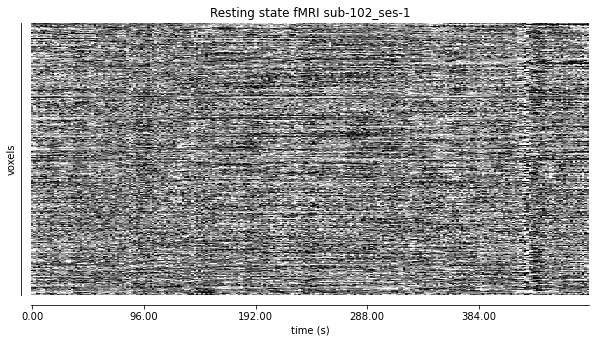

In [28]:
fig = plotting.plot_carpet(img,title=f'Resting state fMRI sub-{sub}_ses-{ses}')

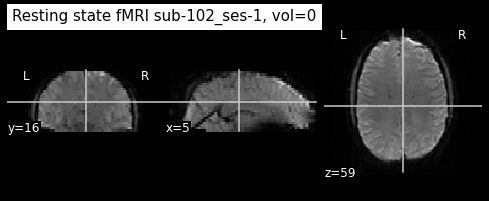

In [29]:
volno = 0
plotting.plot_epi(image.index_img(img, 0), \
                  cmap='gray',title=f'Resting state fMRI sub-{sub}_ses-{ses}, vol={volno}')
plt.show()

## FSL: Brain Extraction Tool (BET2)

In [30]:
#!bet --help

```shell
Usage:    bet <input> <output> [options]

Main bet2 options:
  -o          generate brain surface outline overlaid onto original image
  -m          generate binary brain mask
  -s          generate approximate skull image
  -n          don't generate segmented brain image output
  -f <f>      fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates
  -g <g>      vertical gradient in fractional intensity threshold (-1->1); default=0; positive values give larger brain outline at bottom, smaller at top
  -r <r>      head radius (mm not voxels); initial surface sphere is set to half of this
  -c <x y z>  centre-of-gravity (voxels not mm) of initial mesh surface.
  -t          apply thresholding to segmented brain image and mask
  -e          generates brain surface as mesh in .vtk format

Variations on default bet2 functionality (mutually exclusive options):
  (default)   just run bet2
  -R          robust brain centre estimation (iterates BET several times)
  -S          eye & optic nerve cleanup (can be useful in SIENA - disables -o option)
  -B          bias field & neck cleanup (can be useful in SIENA)
  -Z          improve BET if FOV is very small in Z (by temporarily padding end slices)
  -F          apply to 4D FMRI data (uses -f 0.3 and dilates brain mask slightly)
  -A          run bet2 and then betsurf to get additional skull and scalp surfaces (includes registrations)
  -A2 <T2>    as with -A, when also feeding in non-brain-extracted T2 (includes registrations)

Miscellaneous options:
  -v          verbose (switch on diagnostic messages)
  -h          display this help, then exits
  -d          debug (don't delete temporary intermediate images)
```

In [31]:
#%%time
#!/usr/local/fsl/bin/bet ~/prj/BMED360/Lab6-Networks-Graphs/sub-102_ses-1_T1w ~/prj/BMED360/Lab6-Networks-Graphs/sub-102_ses-1_T1w_brain -R -f 0.5 -g 0 -m

```
CPU times: user 91.3 ms, sys: 38.7 ms, total: 130 ms
Wall time: 8.16 s
```


--> `sub-102_ses-1_T1w_brain.nii.gz` and `sub-102_ses-1_T1w_brain_mask.nii.gz`

## FSL: FEAT

([FEAT](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT/UserGuide) = _FMRI Expert Analysis Tool_ - for preprocessing and statistical analysis of FMRI data)

**First-level analysis | Preprocessing**

_Data_ (4D): ~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.nii.gz<br>
Total volumes: 240; Delete volumes:0; TR: 2.0 s; High pass filter cutoff: 60 s<br>
_Pre-stats_:<br>
Motion correction (MCFLIRT), <br>
Slice timing correction: None<br>
BET brain extraction: Yes<br>
Spatial smoothing: FWHM 5 mm<br>
Temporal filtering Highpass, MELODIC ICA data exploration<br>
_Registration_:<br>
Man structural image: ~/prj/BMED360/Lab6-Networks-Graphs/sub-102_ses-1_T1w_brain.nii.gz; Linear Normal search, BBR<br>
Standard space: /usr/local/fsl/data/standard/MNI151_T1_2mm_brain.nii.gz; Linear: Normal search, 12 DOF<br>
_Misc_: Brain/background threshold: 10%, Noise level: 0.66; Temporal smoothness: 0.34; Z-threshold: 5.3<br>

In [32]:
#!feat ~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/design.fsf

```shell
/usr/local/fsl/bin/mainfeatreg -F 6.00 -d ~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat 
-l ~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/logs/feat2_pre 
-R ~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/report_unwarp.html 
-r ~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/report_reg.html  
-i ~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/example_func.nii.gz  
-h ~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_T1w_brain 
-w  BBR -x 90 -s /usr/local/fsl/data/standard/MNI152_T1_2mm_brain -y 12 -z 90 
Option -F ( FEAT version parameter ) selected with  argument "6.00"
Option -d ( output directory ) selected with  argument "~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat"
Option -l ( logfile )input with argument "~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/logs/feat2_pre"
Option -R ( html unwarping report ) selected with  argument "~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/report_unwarp.html"
Option -r ( html registration report ) selected with  argument "~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/report_reg.html"
Option -i ( main input ) input with argument "~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_task-rest_bold.feat/example_func.nii.gz"
Option -h ( high-res structural image ) selected with  argument "~/prj/BMED360/Lab6-Networks-Graphs/sub-103_ses-1_T1w_brain"
Option -w ( highres dof ) selected with  argument "BBR"
Option -x ( highres search ) selected with  argument "90"
Option -s ( standard image ) selected with  argument "/usr/local/fsl/data/standard/MNI152_T1_2mm_brain"
Option -y ( standard dof ) selected with  argument "12"
Option -z ( standard search ) selected with  argument "90"
```

#### Preprocessing:Stage 1) --> `sub-102_ses-1_task-rest_bold_filtered_func_data.nii.gz`

#### Filtered function ICA report --> `sub-102_ses-1_task-rest_bold.feat/filtered_func_data.ica`


## FSL: MELODIC 

([MELODIC](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MELODIC) = _Multivariate Exploratory Linear Optimized Decomposition into Independent Components_)

Uses Independent Component Analysis (ICA) to decompose a single or multiple 4D data sets into different spatial and temporal components. For ICA group analysis, MELODIC uses either Tensorial Independent Component Analysis (TICA, where data is decomposed into spatial maps, time courses and subject/session modes) or a simpler temporal concatenation approach. MELODIC can pick out different activation and artefactual components without any explicit time series model being specified.

A paper investigating resting-state connectivity using independent component analysis has been published in Philosophical Transactions of the Royal Society. For detail, see a technical report [PDF](https://www.fmrib.ox.ac.uk/datasets/techrep/tr05cb1/tr05cb1.pdf).

![FSL_ICA](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MELODIC?action=AttachFile&do=get&target=tica_diag.png)

## Automatically generated FSL reports


#### Registration

Analysis methods:<br>
FMRI data processing was carried out using FEAT (FMRI Expert Analysis Tool) Version 6.00, part of FSL (FMRIB's Software Library, www.fmrib.ox.ac.uk/fsl). Registration to high resolution structural and/or standard space images was carried out using FLIRT [Jenkinson 2001, 2002].

References:<br>
[Jenkinson 2001] M. Jenkinson and S.M. Smith. A Global Optimisation Method for Robust Affine Registration of Brain Images. Medical Image Analysis 5:2(143-156) 2001.<br>
[Jenkinson 2002] M. Jenkinson, P. Bannister, M. Brady and S. Smith. Improved Optimisation for the Robust and Accurate Linear Registration and Motion Correction of Brain Images. NeuroImage 17:2(825-841) 2002.<br>


#### Pres-stats

Analysis methods:<br>
FMRI data processing was carried out using FEAT (FMRI Expert Analysis Tool) Version 6.00, part of FSL (FMRIB's Software Library, www.fmrib.ox.ac.uk/fsl). The following pre-statistics processing was applied; motion correction using MCFLIRT [Jenkinson 2002]; non-brain removal using BET [Smith 2002]; spatial smoothing using a Gaussian kernel of FWHM 5mm; grand-mean intensity normalisation of the entire 4D dataset by a single multiplicative factor; highpass temporal filtering (Gaussian-weighted least-squares straight line fitting, with sigma=30.0s). ICA-based exploratory data analysis was carried out using MELODIC [Beckmann 2004], in order to investigate the possible presence of unexpected artefacts or activation.

References:<br>
[Jenkinson 2002] M. Jenkinson and P. Bannister and M. Brady and S. Smith. Improved optimisation for the robust and accurate linear registration and motion correction of brain images. NeuroImage 17:2(825-841) 2002.<br>
[Smith 2002] S. Smith. Fast Robust Automated Brain Extraction. Human Brain Mapping 17:3(143-155) 2002.<br>
[Beckmann 2004] C.F. Beckmann and S.M. Smith. Probabilistic Independent Component Analysis for Functional Magnetic Resonance Imaging. IEEE Trans. on Medical Imaging 23:2(137-152) 2004.<br>


#### MELODIC data exploration report


Analysis methods:<br>
Analysis was carried out using Probabilistic Independent Component Analysis [Beckmann 2004] as implemented in MELODIC (Multivariate Exploratory Linear Decomposition into Independent Components) Version 3.15, part of FSL (FMRIB's Software Library, www.fmrib.ox.ac.uk/fsl).
The following data pre-processing was applied to the input data: masking of non-brain voxels; voxel-wise de-meaning of the data; normalisation of the voxel-wise variance;
Pre-processed data were whitened and projected into a 60-dimensional subspace using probabilistic Principal Component Analysis where the number of dimensions was estimated using the Laplace approximation to the Bayesian evidence of the model order [Minka 2000, Beckmann 2004].
The whitened observations were decomposed into sets of vectors which describe signal variation across the temporal domain (time-courses) and across the spatial domain (maps) by optimising for non-Gaussian spatial source distributions using a fixed-point iteration technique [Hyvärinen 1999]. Estimated Component maps were divided by the standard deviation of the residual noise and thresholded by fitting a mixture model to the histogram of intensity values [Beckmann 2004].

References:<br>
[Hyvärinen 1999] A. Hyvärinen. Fast and Robust Fixed-Point Algorithms for Independent Component Analysis. IEEE Transactions on Neural Networks 10(3):626-634, 1999.<br>
[Beckmann 2004] C.F. Beckmann and S.M. Smith. Probabilistic Independent Component Analysis for Functional Magnetic Resonance Imaging. IEEE Transactions on Medical Imaging 23(2):137-152 2004.<br>
[Everson 2000] R. Everson and S. Roberts. Inferring the eigenvalues of covariance matrices from limited, noisy data. IEEE Trans Signal Processing, 48(7):2083-2091, 2000<br>
[Tipping 1999] M.E. Tipping and C.M.Bishop. Probabilistic Principal component analysis. J Royal Statistical Society B, 61(3), 1999.<br>
[Beckmann 2001] C.F. Beckmann, J.A. Noble and S.M. Smith. Investigating the intrinsic dimensionality of FMRI data for ICA. In Seventh Int. Conf. on Functional Mapping of the Human Brain, 2001.<br>
[Minka 2000] T. Minka. Automatic choice of dimensionality for PCA. Technical Report 514, MIT Media Lab Vision and Modeling Group, 2000.


- **Single-session ICA:** This will perform standard 2D ICA on each of the input files. The input data will each be represented as a 2D time x space matrix. MELODIC then de-composes each matrix separately into pairs of time courses and spatial maps. The original data is assumed to be the sum of outer products of time courses and spatial maps. All the different time courses (one per component) will be saved in the mixing matrix melodic_mix and all the spatial maps (one per component) will be saved in the 4D file melodic_IC. <br>When using separate analyses, MELODIC will attempt to find components which are relevant and non-Gaussian relative to the residual fixed-effects within session/subject variation. It is recommended to use this option in order to check for session-specific effects (such as MR artefacts). You will need to use this option if you want to perform MELODIC denoising using fsl_regfilt. When using single-session ICA the component are ordered in order of decreasing amounts of uniquely explained variance.


Melodic results will be in `filtered_func_data.ica`

To view the output report point your web browser at `filtered_func_data.ica/report/00index.html`

In [33]:
#!melodic --help

```shell
Part of FSL (ID: 6.0.4:ddd0a010)
MELODIC (Version 3.15)
 Multivariate Exploratory Linear Optimised Decomposition into Independent Components

Author: Christian F. Beckmann 
 Copyright(c) 2001-2013 University of Oxford

Usage: 
 melodic -i <filename> <options>
 	 	 to run melodic
 melodic -i <filename> --ICs=melodic_IC --mix=melodic_mix <options>
 	 	 to run Mixture Model based inference on estimated ICs
 melodic --help 

Compulsory arguments (You MUST set one or more of):
	-i,--in	input file names (either single file name or comma-separated list or text file)

Optional arguments (You may optionally specify one or more of):
	-o,--outdir	output directory name
	--Oall	        output everything
	-m,--mask	file name of mask for thresholding
	-d,--dim	dimensionality reduction into #num dimensions (default: automatic estimation)
	-a,--approach	approach for multi-session/subject data:
	   concat	temporally-concatenated group-ICA using MIGP ( default )
	   tica  	tensor-ICA
	--report	generate Melodic web report
	--CIFTI	        input/output as CIFTI (warning: auto-dimensionality estimation for CIFTI data is currently inaccurate)
	--vn,--varnorm	switch off variance normalisation
	-v,--verbose	switch on diagnostic messages



	--nomask	switch off masking
	--update_mask	switch off mask updating
	--nobet		switch off BET
	--bgthreshold	brain / non-brain threshold (only if --nobet selected)

	--dimest	use specific dim. estimation technique: lap, bic, mdl, aic, mean (default: lap)
	--sep_vn	switch on separate variance nomalisation for each input dataset (off by default)
	--disableMigp	switch off MIGP data reduction when using -a concat (full temporal concatenation will be used)
	--migpN	Number of internal Eigenmaps
	--migp_shuffle	Randomise MIGP file order (default: TRUE)
	--migp_factor	Internal Factor of mem-threshold relative to number of Eigenmaps (default: 2)
	-n,--numICs	numer of IC's to extract (for deflation approach)
	--nl		nonlinearity: gauss, tanh, pow3 (default), pow4
	--covarweight	voxel-wise weights for the covariance matrix (e.g. segmentation information)
	--eps	minimum error change
	--epsS	minimum error change for rank-1 approximation in TICA
	--maxit		maximum number of iterations before restart
	--maxrestart	maximum number of restarts

	--mmthresh	threshold for Mixture Model based inference
	--no_mm		switch off mixture modelling on IC maps
 
	--ICs		input filename of the IC components file for mixture modelling
	--mix		input filename of mixing matrix for mixture modelling / filtering
	--smode		input filename of matrix of session modes for report generation
	-f,--filter	list of component numbers to remove
 
	--bgimage	specify background image for report (default: mean image)
 
	--tr		TR in seconds
	--logPower	calculate log of power for frequency spectrum

	--Tdes	        design matrix across time-domain
	--Tcon	        t-contrast matrix across time-domain
	--Sdes	        design matrix across subject-domain
	--Scon	        t-contrast matrix across subject-domain
	--Ounmix	output unmixing matrix
	--Ostats	output thresholded maps and probability maps
	--Opca		output PCA results
	--Owhite	output whitening/dewhitening matrices
	--Oorig		output the original ICs
	--Omean		output mean volume

	-V,--version	prints version information
	--copyright	prints copyright information
	-h,--help	prints this help message
	--debug	        switch on debug messages
	--report_maps	control string for spatial map images (see slicer)
```


In [34]:
#%%time

#!melodic -i ~/prj/BMED360/Lab6-Networks-Graphs/sub-102_ses-1_task-rest_bold.nii.gz -o ~/prj/BMED360/Lab6-Networks-Graphs/sub-102_ses-1_MELODIC  --tr=2.0 --report --Oall


```
CPU times: user 8.85 s, sys: 2.66 s, total: 11.5 s
Wall time: 14min 30s
```


#### Selected components

(Thresholded IC map, alternative hypothesis test at p > 0.5: IC_5_thresh.png / Timecourse: t5.png / Powerspectrum of timecourse: f5.png) <br>

MELODIC Component 5 | 2.33 % of explained variance;     1.83 % of total variance <br>
MELODIC Component 13 | 1.90 % of explained variance;     1.50 % of total variance <br>
MELODIC Component 18 | 1.84 % of explained variance;     1.45 % of total variance <br>

#### MELODIC Component 5
Thresholded IC map (IC_5_thresh.png), alternative hypothesis test at p > 0.5
![ica_5](./assets/IC_5_thresh.png)

Timecourse (t5.png)
![ica_5_t5](./assets/t5.png)

Powerspectrum of timecourse (f5.png)
![ica_5_f5](./assets/f5.png)

In [35]:
melodic = './data/sub-102_ses-1_MELODIC/filtered_func_data.ica/melodic_IC.nii.gz'
mean_img = './data/sub-102_ses-1_MELODIC/filtered_func_data.ica/mean.nii.gz'
anat = './data/sub-102_ses-1_MELODIC/sub-102_ses-1_T1w.nii.gz'
brain = './data/sub-102_ses-1_MELODIC/sub-102_ses-1_T1w_brain.nii.gz'
img = nib.load(melodic)
data = img.get_fdata()

print(data.shape)

comp = 4
ic_comp = image.index_img(img, comp)
print(ic_comp.shape)

(128, 128, 26, 60)
(128, 128, 26)


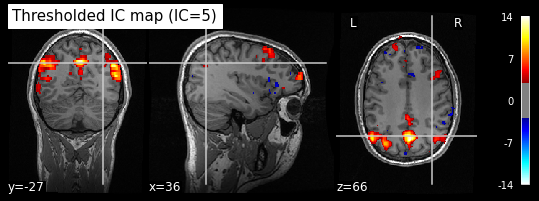

In [36]:
from nilearn import plotting

# Visualizing t-map image on EPI template with manual
# positioning of coordinates using cut_coords given as a list
plotting.plot_stat_map(ic_comp, 
                        bg_img = anat, 
                        threshold=3, 
                        title="Thresholded IC map (IC=5)", 
                        cut_coords=[36, -27, 66],
                        dim = -0.8)

plt.show()

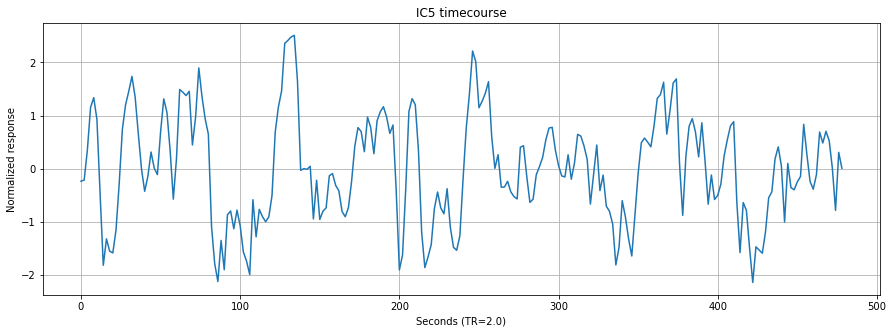

In [37]:
plt.figure(figsize=(15, 5))

df = pd.read_fwf('data/sub-102_ses-1_MELODIC/filtered_func_data.ica/report/t5.txt', header=None)
df.columns = ['IC5']

sig = df.to_numpy()
sig = sig.flatten()
n = len(sig)

TR = 2.0
time_vec = np.arange(0, TR*n, TR)
plt.plot(time_vec, sig)
plt.title("IC5 timecourse")
plt.xlabel("Seconds (TR=2.0)")
plt.ylabel("Normalized response")
plt.grid()
plt.show()

#### Plot the power spectral density and the magnitude spectrum.

Compute the magnitude spectrum of x

The power spectral density 𝑃𝑥𝑥 by Welch's average periodogram method, and then compute the magnitude spectrum of x.

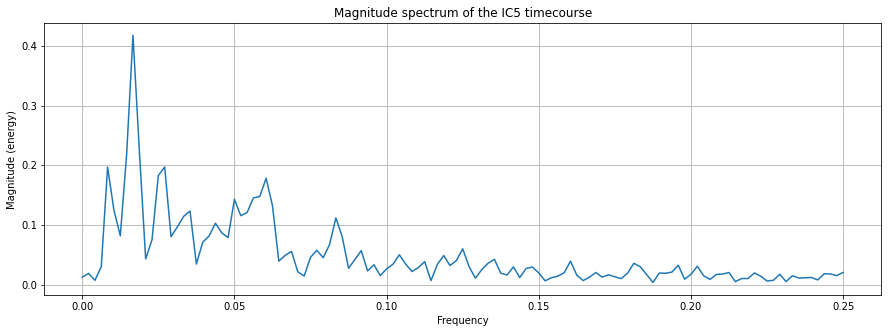

In [38]:
plt.figure(figsize=(15, 5))

Fs = 1 / TR   # Sample per time unit
# plt.psd(sig, Fs=Fs)
plt.magnitude_spectrum(sig, Fs=Fs)
plt.title("Magnitude spectrum of the IC5 timecourse")
plt.grid()
plt.show()

# Connectome example from Nilearn

This example is adopted form https://nilearn.github.io/auto_examples/03_connectivity/plot_sphere_based_connectome.html

## Extract signals on spheres and plot a connectome


This example shows how to extract signals from spherical regions. We show how to build spheres around user-defined coordinates, as well as centered on coordinates from the Power-264 atlas [1], and the Dosenbach-160 atlas [2].

References

[1] Power, Jonathan D., et al. “Functional network organization of the human brain.” Neuron 72.4 (2011): 665-678.

[2] Dosenbach N.U., Nardos B., et al. “Prediction of individual brain maturity using fMRI.”, 2010, Science 329, 1358-1361.

We estimate connectomes using two different methods: sparse inverse covariance (not shown) and **partial_correlation**, to recover the functional brain **networks structure**.

We’ll start by extracting signals from Default Mode Network regions and computing a connectome from them.

In [39]:
from nilearn import datasets
dataset = datasets.fetch_development_fmri(n_subjects=1)

# print basic information on the dataset
print('First subject functional nifti image (4D) is at: %s' % dataset.func[0])  # 4D data

First subject functional nifti image (4D) is at: /Users/arvid/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


### Coordinates of Default Mode Network¶

In [40]:
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
    'Posterior Cingulate Cortex',
    'Left Temporoparietal junction',
    'Right Temporoparietal junction',
    'Medial prefrontal cortex',
    ]

### Extracts signal from sphere around DMN seeds

We can compute the mean signal within spheres of a fixed radius around a sequence of (x, y, z) coordinates with the object nilearn.input_data.NiftiSpheresMasker. The resulting signal is then prepared by the masker object: Detrended, band-pass filtered and standardized to 1 variance.

In [41]:
from nilearn import input_data

masker = input_data.NiftiSpheresMasker(
    dmn_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=2)

# Additionally, we pass confound information to ensure our extracted
# signal is cleaned from confounds.

func_filename = dataset.func[0]
confounds_filename = dataset.confounds[0]

time_series = masker.fit_transform(func_filename,
                                   confounds=[confounds_filename])

[Memory]0.0s, 0.0min    : Loading filter_and_extract...


### Display time series

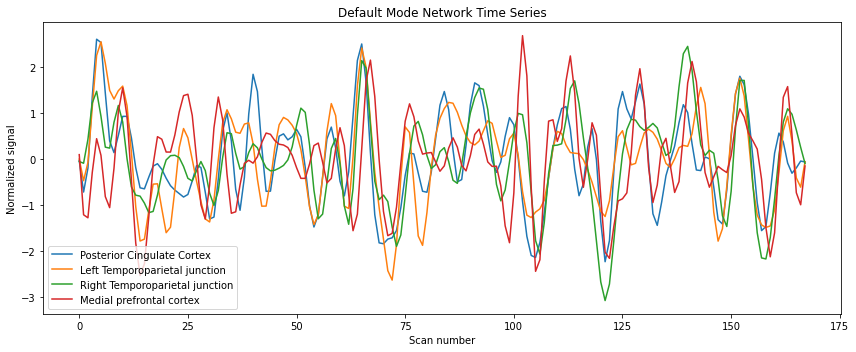

In [42]:
plt.figure(figsize=(12, 5))

for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)


plt.title('Default Mode Network Time Series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.legend()
plt.tight_layout()

### Compute partial correlation matrix

Using object nilearn.connectome.ConnectivityMeasure: Its default covariance estimator is Ledoit-Wolf, allowing to obtain accurate partial correlations.


In [43]:
from nilearn.connectome import ConnectivityMeasure
connectivity_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrix = connectivity_measure.fit_transform([time_series])[0]

In [44]:
print(f'partial_correlation_matrix:\n{partial_correlation_matrix}')

partial_correlation_matrix:
[[ 1.          0.53582652  0.38606041 -0.1111872 ]
 [ 0.53582652  1.          0.17332681  0.12426972]
 [ 0.38606041  0.17332681  1.          0.39958164]
 [-0.1111872   0.12426972  0.39958164  1.        ]]


In [45]:
tri_lower_no_diag = np.tril(partial_correlation_matrix, k=-1)
print(f'tri_lower_no_diag:\n{tri_lower_no_diag}')

tri_lower_no_diag:
[[ 0.          0.          0.          0.        ]
 [ 0.53582652  0.          0.          0.        ]
 [ 0.38606041  0.17332681  0.          0.        ]
 [-0.1111872   0.12426972  0.39958164  0.        ]]


In [46]:

list(tri_lower_no_diag[np.tril_indices(tri_lower_no_diag.shape[0], k = -1)].round(2))

[0.54, 0.39, 0.17, -0.11, 0.12, 0.4]

### Display connectome
We display the graph of connections with `nilearn.plotting.plot_connectome`

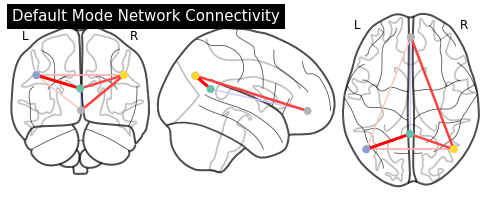

In [47]:
plotting.plot_connectome(partial_correlation_matrix, dmn_coords,
                         title="Default Mode Network Connectivity")
plt.show()

Display connectome with hemispheric projections. Notice (0, -52, 18) is included in both hemispheres since x == 0.

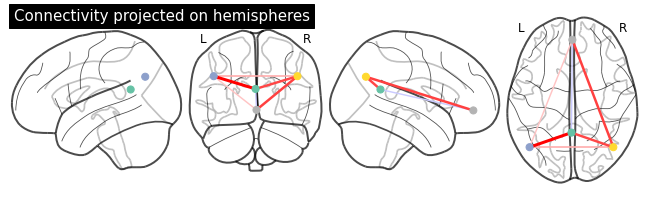

In [48]:
plotting.plot_connectome(partial_correlation_matrix, dmn_coords,
                         title="Connectivity projected on hemispheres",
                         display_mode='lyrz')
plt.show()

### 3D visualization in a web browser

An alternative to `nilearn.plotting.plot_connectome` is to use `nilearn.plotting.view_connectome`, which gives more interactive visualizations in a web browser. See [3D Plots of connectomes](https://nilearn.github.io/plotting/index.html#interactive-connectome-plotting) for more details.

In [49]:
view = plotting.view_connectome(partial_correlation_matrix, dmn_coords)

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [50]:
# uncomment this to open the plot in a web browser:
# view.open_in_browser()

### We have represented the functional connectivity of DMN as a weighted undirected graph:

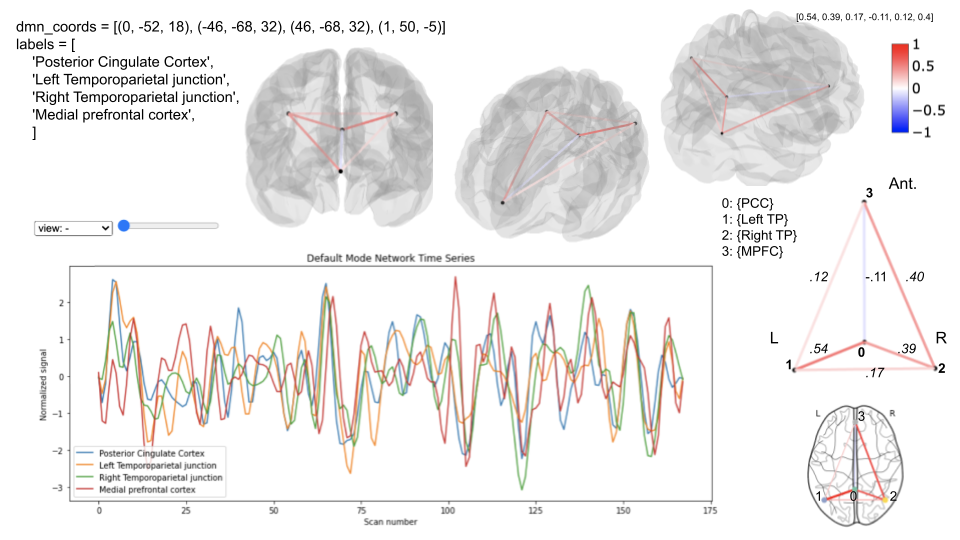

In [51]:
from IPython.display import Image
Image("./assets/BMED360_Lab6_DNM_connect.png")

# A final example with an OpenNeuro dataset

# Feature extraction using ICA from resting state networks 

(Using preprocessed data with `fmriprep` from HC subject `sub-10228` in the OpenNeuro collection [ds000030](https://openneuro.org/datasets/ds000030/versions/1.0.0))

Adopted from **Gili Karni**, Princeton University:<br> https://github.com/karnigili/Computational-Neuroscience/blob/master/rs_fmri_networks_ICA.ipynb  (MIT License)

In [52]:
# OLD: path='%s/sub-10228_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (openneuro_dir)
path='%s/fmriprep/sub-10228/func/sub-10228_task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz' % (openneuro_dir)

img = load_image(path)
data = img.get_fdata()
TR = get_TR(img)
slices = get_slices(img)
    
print('TR: {}'.format(TR))
print('# of slices: {}'.format(slices))
print('data.shape:', data.shape)

TR: 2.0
# of slices: 49
data.shape: (65, 77, 49, 152)


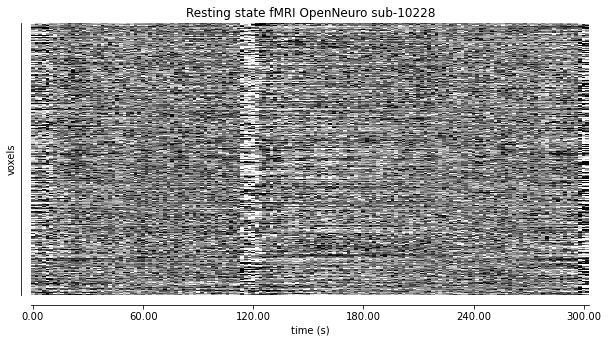

In [53]:
fig = plotting.plot_carpet(img,title=f'Resting state fMRI OpenNeuro sub-10228')

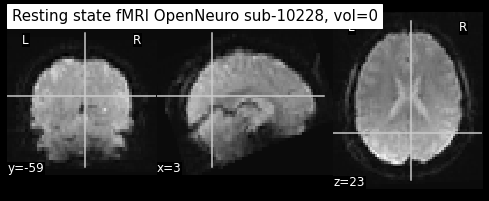

In [54]:
volno = 0
plotting.plot_epi(image.index_img(img, 0), \
                  cmap='gray',title=f'Resting state fMRI OpenNeuro sub-10228, vol={volno}')
plt.show()

## Feature extraction using ICA from resting state networks

In [55]:
from nilearn import input_data
from nilearn import datasets
from nilearn import plotting
from nilearn.plotting import plot_prob_atlas, plot_roi, plot_matrix

from nilearn.decomposition import CanICA 
from nilearn import image
from nilearn.regions import RegionExtractor


from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')

In [56]:
## create masker based on the atlas 
## and create a time series of the uploaded image using the masker
def create_mask(atlas_img, fmri_img):
  # generates a mask given img and atlas
  masker=NiftiLabelsMasker(labels_img=atlas_img, standardize=True)
  time_series=masker.fit_transform(fmri_img)
  
  return time_series

# using the correlation measures defined above, 
# we calculate the correaltion matrixes
def calc_correlation_matrix(time_series):
  # given a time series, return a correlation matrix
  # we regress out the confounds (as found in the 
  # preprocessing stage)
  return correlation_measure.fit_transform([time_series])[0]

#and we plot,
def plot_cor_matrix(correlation_matrix, title, labels=None):
  ## plot the correlation matrix
  
    
  np.fill_diagonal(correlation_matrix, 0)
  if labels:
    plot_matrix(correlation_matrix, figure=(10, 8), 
              labels=labels,
                       vmax=0.8, vmin=-0.8, reorder=True)
  else:
    plot_matrix(correlation_matrix, figure=(10, 8), 
              labels=range(correlation_matrix.shape[1]),
                       vmax=0.8, vmin=-0.8, reorder=True)
  plt.title(title)
  plt.show()

## Preparing for atlas-based analysis

We include two types of atlases. The first is the Harvard-Oxford probabilistic atlas (Makris et al., 2006; Frazier et al., 2005; Desikan et al., 2006; Goldstein et al., 2007) and the second is Smith's ICA functional map (Smith et al., 2009).

The Harvard-Oxford atals is based on MNI defined regions and the Smith's atlas reflecs regions resulting from an independent analyses of resting and activation brain dynamics.

Smith's includes 10 resting-state networks (rsns)

In [57]:
## import an existing map

# Harvard-Oxford
'''
retrived from https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases
'''
harvard_dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
harvard_maps = harvard_dataset.maps
harvard_labels = harvard_dataset.labels

In [58]:
## load the smith (ICA based) mask
## 'rsn10': 10 ICA maps from the above that matched across task and rest
# http://brainmap.org/pubs/SmithPNAS09.pdf

smith_atlas = datasets.fetch_atlas_smith_2009()
smith_atlas_rs_networks = smith_atlas.rsn10


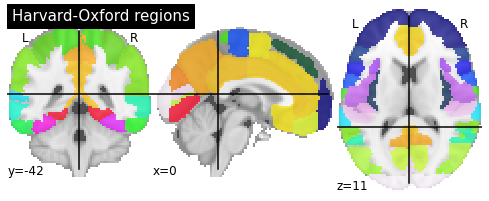

In [59]:
# plot the ROIs based on the map chosen
plot_roi(harvard_maps, title='Harvard-Oxford regions')
plt.show()

In [60]:
%%time
extraction = RegionExtractor(smith_atlas_rs_networks, min_region_size=800,
                             threshold=98, thresholding_strategy='percentile')

# Just call fit() to execute region extraction procedure
extraction.fit()
smith_maps = extraction.regions_img_

CPU times: user 28min, sys: 32 s, total: 28min 32s
Wall time: 1min 51s


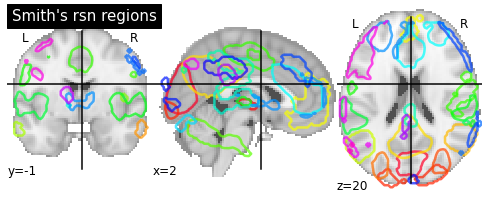

In [61]:
plotting.plot_prob_atlas(smith_maps, title="Smith's rsn regions")
plt.show()

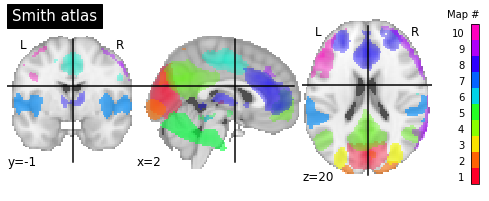

In [62]:
plotting.plot_prob_atlas(smith_atlas_rs_networks,
                         title='Smith atlas',  
                         colorbar=True)
plotting.show()

In [63]:
# An example for correlation matrix using both atlases


# Smith
# We take the first out of the 10 rsns
smith_1st_rsn=image.index_img(smith_atlas_rs_networks, 0)

In [64]:
smith_time_series=create_mask(smith_1st_rsn, img)

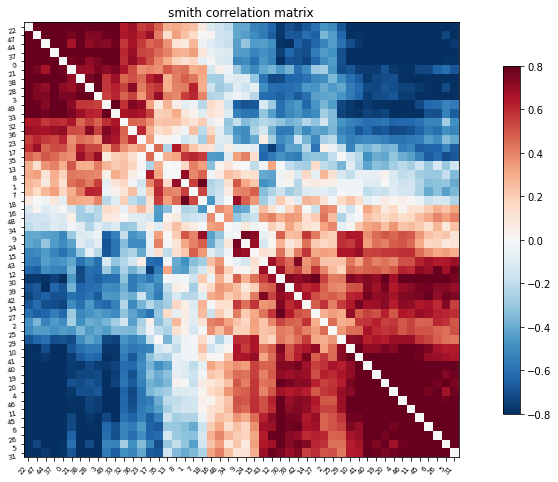

In [65]:
smith_time_series=create_mask(smith_1st_rsn, img)
cropped_smith_time_series=np.array([e[:50] for e in smith_time_series])
smith_cor_matrix=calc_correlation_matrix(cropped_smith_time_series)
plot_cor_matrix(smith_cor_matrix, 'smith correlation matrix')

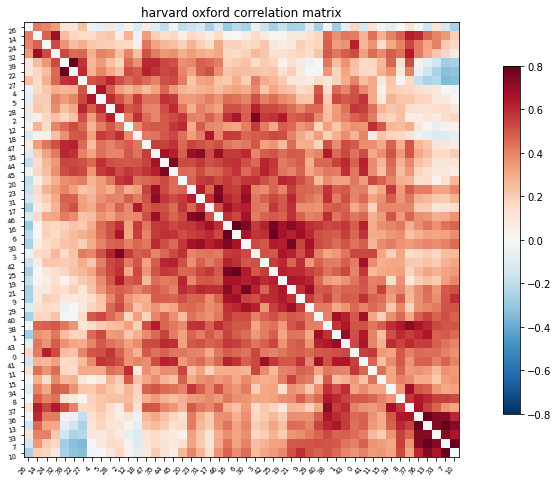

In [66]:
## plot the correlation matrix
# Harvard Oxford
harvard_oxford_time_series=create_mask(harvard_maps, img)
harvard_oxford_cor_matrix=calc_correlation_matrix(harvard_oxford_time_series)
plot_cor_matrix(harvard_oxford_cor_matrix, 'harvard oxford correlation matrix')


### ICA analysis (Varoquaux et al., 2010)

In [67]:
# perform an ICA given the subset of the data. 
ica = CanICA(n_components=20,
                random_state=0)

ica.fit(img)

CanICA(random_state=0)

In [68]:
ica.components_.shape

(20, 44591)

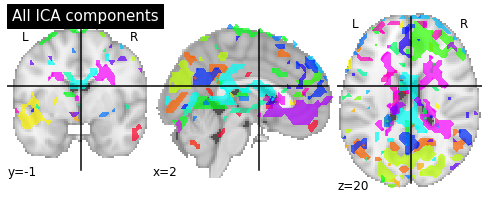

In [69]:
# exctract a 3D representation of the componenets and plot
components_img=ica.components_img_
plot_prob_atlas(components_img, title='All ICA components')
plt.show()

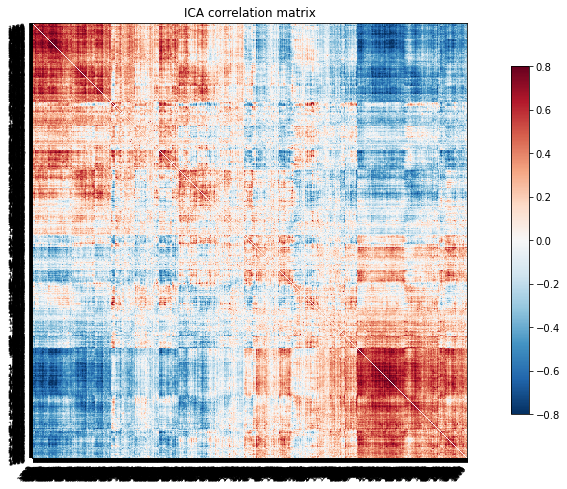

CPU times: user 44.1 s, sys: 1.18 s, total: 45.3 s
Wall time: 38.5 s


In [70]:
%%time
# ICA
components_img_1st=image.index_img(components_img, 0)
ica_time_series=create_mask(components_img_1st, img)
ica_cor_matrix=calc_correlation_matrix(ica_time_series)
plot_cor_matrix(ica_cor_matrix, 'ICA correlation matrix')

In [71]:
ica_time_series.data.shape

(152, 1783)


Varoquaux G. et al. “A group model for stable multi-subject ICA on fMRI datasets”, NeuroImage Vol 51 (2010), p. 288-299

Makris N, Goldstein JM, Kennedy D, Hodge SM, Caviness VS, Faraone SV, Tsuang MT, Seidman LJ. Decreased volume of left and total anterior insular lobule in schizophrenia. Schizophr Res. 2006 Apr;83(2-3):155-71

Frazier JA, Chiu S, Breeze JL, Makris N, Lange N, Kennedy DN, Herbert MR, Bent EK, Koneru VK, Dieterich ME, Hodge SM, Rauch SL, Grant PE, Cohen BM, Seidman LJ, Caviness VS, Biederman J. Structural brain magnetic resonance imaging of limbic and thalamic volumes in pediatric bipolar disorder. Am J Psychiatry. 2005 Jul;162(7):1256-65

Desikan RS, Ségonne F, Fischl B, Quinn BT, Dickerson BC, Blacker D, Buckner RL, Dale AM, Maguire RP, Hyman BT, Albert MS, Killiany RJ. An automated labeling system for subdividing the human cerebral cortex on MRI scans into gyral based regions of interest. Neuroimage. 2006 Jul 1;31(3):968-80.

Goldstein JM, Seidman LJ, Makris N, Ahern T, O'Brien LM, Caviness VS Jr, Kennedy DN, Faraone SV, Tsuang MT. Hypothalamic abnormalities in schizophrenia: sex effects and genetic vulnerability. Biol Psychiatry. 2007 Apr 15;61(8):935-45

Smith SM, Fox PT, Miller KL, Glahn DC, Fox PM, Mackay CE, Filippini N, Watkins KE, Toro R, Laird AR, and Beckmann CF. 2009. Correspondence of the brain’s functional architecture during activation and rest. Proc Natl Acad Sci USA (PNAS), 106(31):13040-13045. [[link](https://www.pnas.org/content/106/31/13040)]